## Import Libraries

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# @Time    : 18-5-23 上午11:33
# @Author  : Luo Yao
# @Site    : http://icode.baidu.com/repos/baidu/personal-code/Luoyao
# @File    : test_lanenet.py
# @IDE: PyCharm Community Edition
"""
测试LaneNet模型
"""
import os
import os.path as ops
import argparse
import time
import math

import tensorflow as tf
import glob
import glog as log
import numpy as np
import matplotlib.pyplot as plt
import cv2
try:
    from cv2 import cv2
except ImportError:
    pass
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from lanenet_model import lanenet_merge_model
from lanenet_model import lanenet_cluster
from lanenet_model import lanenet_postprocess
from config import global_config
import random
CFG = global_config.cfg
VGG_MEAN = [103.939, 116.779, 123.68]
print("done")

done


In [2]:
"""
def init_args():

    parser = argparse.ArgumentParser()
    parser.add_argument('--image_path', type=str, help='The image path or the src image save dir')
    parser.add_argument('--weights_path', type=str, help='The model weights path')
    parser.add_argument('--is_batch', type=str, help='If test a batch of images', default='false')
    parser.add_argument('--batch_size', type=int, help='The batch size of the test images', default=32)
    parser.add_argument('--save_dir', type=str, help='Test result image save dir', default=None)
    parser.add_argument('--use_gpu', type=int, help='If use gpu set 1 or 0 instead', default=1)

    return parser.parse_args()
"""

def test_lanenet(image_path, weights_path, use_gpu):
    """

    :param image_path:
    :param weights_path:
    :param use_gpu:
    :return:
    """
    assert ops.exists(image_path), '{:s} not exist'.format(image_path)

    log.info('开始读取图像数据并进行预处理')
    t_start = time.time()
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_vis = image
    image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_LINEAR)
    image = image - VGG_MEAN
    log.info('图像读取完毕, 耗时: {:.5f}s'.format(time.time() - t_start))

    input_tensor = tf.placeholder(dtype=tf.float32, shape=[1, 256, 512, 3], name='input_tensor')
    phase_tensor = tf.constant('train', tf.string)

    net = lanenet_merge_model.LaneNet(phase=phase_tensor, net_flag='vgg')
    binary_seg_ret, instance_seg_ret = net.inference(input_tensor=input_tensor, name='lanenet_loss')

    cluster = lanenet_cluster.LaneNetCluster()
    print("hello")
    postprocessor = lanenet_postprocess.LaneNetPoseProcessor()

    saver = tf.train.Saver()

    # Set sess configuration
    if use_gpu:
        sess_config = tf.ConfigProto(device_count={'GPU': 1})
    else:
        sess_config = tf.ConfigProto(device_count={'GPU': 0})
    sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TEST.GPU_MEMORY_FRACTION
    sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH
    sess_config.gpu_options.allocator_type = 'BFC'

    sess = tf.Session(config=sess_config)

    with sess.as_default():

        saver.restore(sess=sess, save_path=weights_path)

        t_start = time.time()
        binary_seg_image, instance_seg_image = sess.run([binary_seg_ret, instance_seg_ret],
                                                        feed_dict={input_tensor: [image]})
        t_cost = time.time() - t_start
        log.info('单张图像车道线预测耗时: {:.5f}s'.format(t_cost))

        binary_seg_image[0] = postprocessor.postprocess(binary_seg_image[0])
        mask_image = cluster.get_lane_mask(binary_seg_ret=binary_seg_image[0],
                                           instance_seg_ret=instance_seg_image[0])
        # mask_image = cluster.get_lane_mask_v2(instance_seg_ret=instance_seg_image[0])
        # mask_image = cv2.resize(mask_image, (image_vis.shape[1], image_vis.shape[0]),
        #                         interpolation=cv2.INTER_LINEAR)

        ele_mex = np.max(instance_seg_image[0], axis=(0, 1))
        for i in range(3):
            if ele_mex[i] == 0:
                scale = 1
            else:
                scale = 255 / ele_mex[i]
            instance_seg_image[0][:, :, i] *= int(scale)
        embedding_image = np.array(instance_seg_image[0], np.uint8)

        #mask_image = cluster.get_lane_mask_v2(instance_seg_ret=embedding_image)
        #mask_image = cv2.resize(mask_image, (image_vis.shape[1], image_vis.shape[0]),
        #                         interpolation=cv2.INTER_LINEAR)
        cv2.imwrite('mask_image.png', mask_image)
        cv2.imwrite('binary_ret.png', binary_seg_image[0] * 255)
        cv2.imwrite('instance_ret.png', embedding_image)
        """
        plt.figure('mask_image')
        plt.imshow(mask_image[:, :, (2, 1, 0)])
        plt.figure('src_image')
        plt.imshow(image_vis[:, :, (2, 1, 0)])
        plt.figure('instance_image')
        plt.imshow(embedding_image[:, :, (2, 1, 0)])
        plt.figure('binary_image')
        plt.imshow(binary_seg_image[0] * 255, cmap='gray')
        plt.show()
        """
    sess.close()

    return

class LaneNetModel(object):
  """Class to load lanenet model and run inference."""


  def __init__(self, weights_path, use_gpu=1):
    
    self.input_tensor = tf.placeholder(dtype=tf.float32, shape=[1, None, None, 3], name='input_tensor')
    phase_tensor = tf.constant('train', tf.string)
    
    net = lanenet_merge_model.LaneNet(phase=phase_tensor, net_flag='vgg')
    self.binary_seg_ret, self.instance_seg_ret = net.inference(input_tensor=self.input_tensor, name='lanenet_loss')

    self.cluster = lanenet_cluster.LaneNetCluster()
    print("hello")
    self.postprocessor = lanenet_postprocess.LaneNetPoseProcessor()
    
    saver = tf.train.Saver()

    # Set sess configuration
    try:
        sess_config = tf.ConfigProto(device_count={'GPU': 1})
    except:
        sess_config = tf.ConfigProto(device_count={'GPU': 0})
        
    sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TEST.GPU_MEMORY_FRACTION
    sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH
    sess_config.gpu_options.allocator_type = 'BFC'

    self.sess = tf.Session(config=sess_config)

    with self.sess.as_default():

        saver.restore(sess=self.sess, save_path=weights_path)

  def run(self, image):
    image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_LINEAR)
    image = image - VGG_MEAN
    binary_seg_image, instance_seg_image = self.sess.run([self.binary_seg_ret, self.instance_seg_ret],
                                                        feed_dict={self.input_tensor: [image]})
    
    binary_seg_image[0] = self.postprocessor.postprocess(binary_seg_image[0])
    mask_image = self.cluster.get_lane_mask(binary_seg_ret=binary_seg_image[0],
                                       instance_seg_ret=instance_seg_image[0])
    
    return binary_seg_image[0], mask_image
    #return binary_seg_image, instance_seg_image
    

print("done")
image_dir = 'data/tusimple_test_image/0.jpg'
weights_path = '/host/datasets/incubator/tuSimple/models/original_model/Tusimple_LaneNet_Model_Weights/tusimple_lanenet_vgg_2018-05-21-11-11-03.ckpt-94000'

MODEL = LaneNetModel(weights_path)

done
hello
INFO:tensorflow:Restoring parameters from /host/datasets/incubator/tuSimple/models/original_model/Tusimple_LaneNet_Model_Weights/tusimple_lanenet_vgg_2018-05-21-11-11-03.ckpt-94000


I0818 00:18:55.022838 727 tf_logging.py:116] Restoring parameters from /host/datasets/incubator/tuSimple/models/original_model/Tusimple_LaneNet_Model_Weights/tusimple_lanenet_vgg_2018-05-21-11-11-03.ckpt-94000


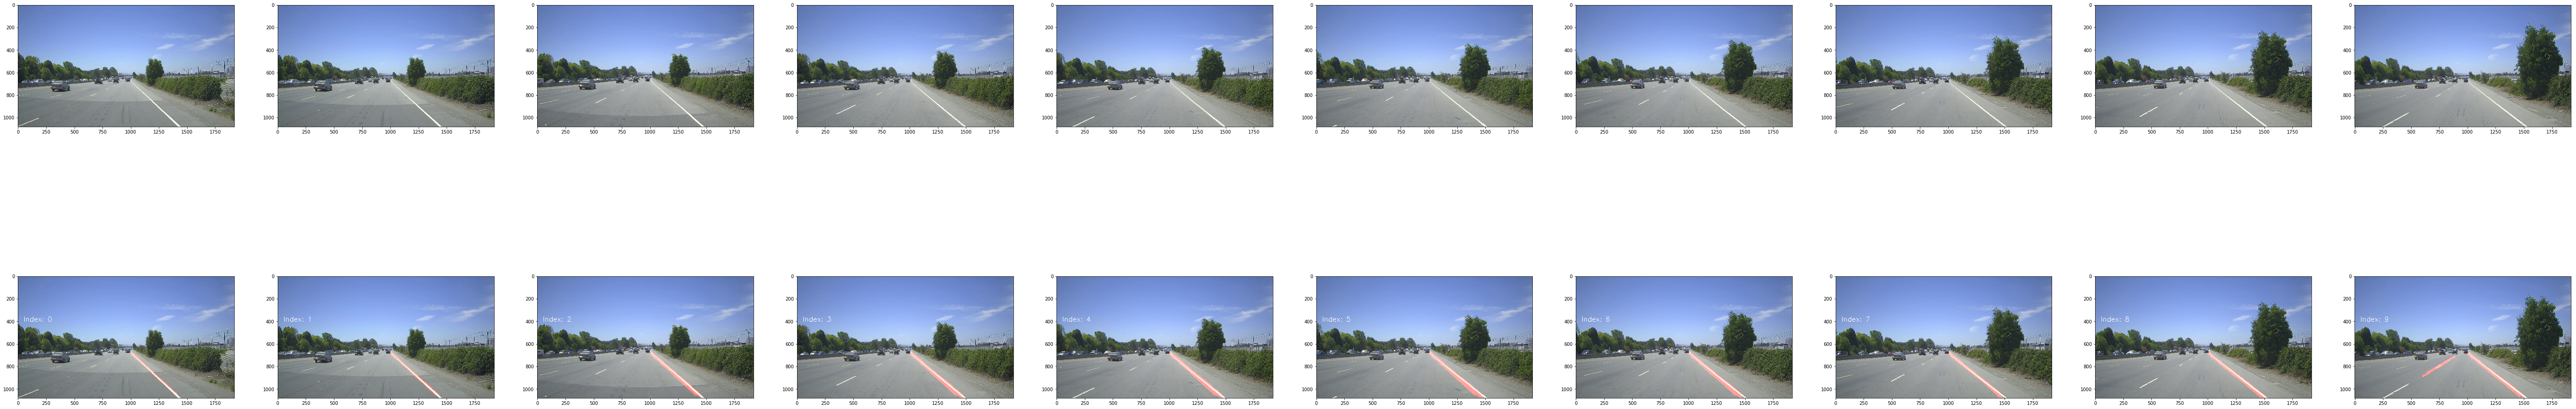

In [27]:
index = 0
font = cv2.FONT_HERSHEY_SIMPLEX
previous_mask_gray = None
previous_mask_grays = []
N = 5
def predict(image):
    global index
    global previous_mask_gray
    
    height = image.shape[0]
    width = image.shape[1]
    result = np.copy(image)
    #result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    seg_image, mask_image = MODEL.run(image)
    mask_image = cv2.resize(mask_image, (width, height))
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_RGB2GRAY)
    if (previous_mask_gray is not None):
        mask_image_gray_combined = mask_image_gray + np.sum(previous_mask_grays,axis=0)
    else:
        mask_image_gray_combined = mask_image_gray
    previous_mask_gray = mask_image_gray
    previous_mask_grays.append(mask_image_gray)
    if (len(previous_mask_grays) > N):
        del previous_mask_grays[0]
    mask_image_copy = np.copy(mask_image)
    mask_image_copy[mask_image_gray_combined!=0] = [255,0,0]
    
    result = cv2.addWeighted(result, 1, mask_image_copy, 0.9, 0)
    cv2.putText(result, "Index: " + str(index), (50, 400), font, 2.0, (255, 255, 255), 2, cv2.LINE_AA)
    index += 1
    
    return result
image_dir = '/host/datasets/incubator/MKZ_data_20180726/test8/frames/frame00.png'
image_paths = glob.glob('/host/datasets/incubator/MKZ_data_20180726/test8/frames/*.png')
num_examples = 10
fig, axs = plt.subplots(2, num_examples, figsize=(100,20))
axs = axs.ravel()

for i in range(num_examples):
    #index = random.randint(0, len(image_paths)-1)
    index = i
    image = cv2.imread(image_paths[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = predict(image)
    
    axs[i].imshow(image)
    axs[i+num_examples].imshow(result)

## Try on Video

In [28]:
MODEL_NAME = "LaneNet" # can be "LaneNet"
VIDEO = "test8" # choose which video aka "test5", "test6", "test7", "test8", "test9", "traffic"
project_output = ('/host/datasets/incubator/tuSimple/results/%s/%s/inference_only/original_model/' % (MODEL_NAME,VIDEO))               
if not os.path.exists(project_output):
    os.makedirs(project_output)
project_output += ('%s_with_%d_previous_masks.mp4' % (VIDEO, N))
index = 0
project_input = ("/host/datasets/incubator/MKZ_data_20180726/%s/%s.mp4" % (VIDEO,VIDEO))
index = -1
clip1 = VideoFileClip(project_input);
white_clip = clip1.fl_image(predict)
%time white_clip.write_videofile(project_output, audio = False);

[MoviePy] >>>> Building video /host/datasets/incubator/tuSimple/results/LaneNet/test8/inference_only/original_model/test8_with_5_previous_masks.mp4
[MoviePy] Writing video /host/datasets/incubator/tuSimple/results/LaneNet/test8/inference_only/original_model/test8_with_5_previous_masks.mp4


 16%|█▌        | 60/371 [00:05<00:30, 10.04it/s]E0818 00:42:04.532004 727 lanenet_cluster.py:58] Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
 17%|█▋        | 64/371 [00:06<00:30, 10.07it/s]E0818 00:42:04.910501 727 lanenet_cluster.py:58] Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
 18%|█▊        | 68/371 [00:06<00:30, 10.08it/s]E0818 00:42:05.304443 727 lanenet_cluster.py:58] Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
 93%|█████████▎| 344/371 [00:36<00:02,  9.37it/s]E0818 00:42:35.351665 727 lanenet_cluster.py:58] Expected 2D array, got 1D array 

[MoviePy] Done.
[MoviePy] >>>> Video ready: /host/datasets/incubator/tuSimple/results/LaneNet/test8/inference_only/original_model/test8_with_5_previous_masks.mp4 

CPU times: user 6min 44s, sys: 8.7 s, total: 6min 52s
Wall time: 40.5 s
